In [10]:
# File 3: Sentiment-Performance Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [11]:
# Load cleaned data
print("Loading cleaned data...")

sentiment_df = pd.read_csv('cleaned_sentiment.csv')
merged_df = pd.read_csv('cleaned_merged_trades.csv')
daily_stats = pd.read_csv('daily_trader_stats.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
merged_df['trade_date'] = pd.to_datetime(merged_df['trade_date'])
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

print(f"Loaded {len(merged_df)} trades with sentiment data")

Loading cleaned data...
Loaded 211224 trades with sentiment data


Trades with sentiment: 211218

PERFORMANCE BY SENTIMENT CATEGORY

Performance Metrics by Sentiment:
  sentiment_category     total_pnl    avg_pnl  median_pnl      pnl_std  \
0       Extreme Fear  7.391102e+05  34.537862         0.0  1136.056091   
2               Fear  3.357155e+06  54.290400         0.0   935.355438   
4            Neutral  1.292921e+06  34.307718         0.0   517.122220   
3              Greed  2.150129e+06  42.743559         0.0  1116.028390   
1      Extreme Greed  2.715171e+06  67.892861         0.0   766.828294   

   num_trades  num_profitable  num_closed  avg_trade_size  avg_return_pct  \
0       21400            7931       10406     5349.731843        0.432142   
2       61837           26019       29808     7816.109931        1.540920   
4       37686           14961       18159     4782.732661        0.993581   
3       50303           19358       25176     5736.884375        1.964567   
1       39992           18594       20853     3112.251565        4.001

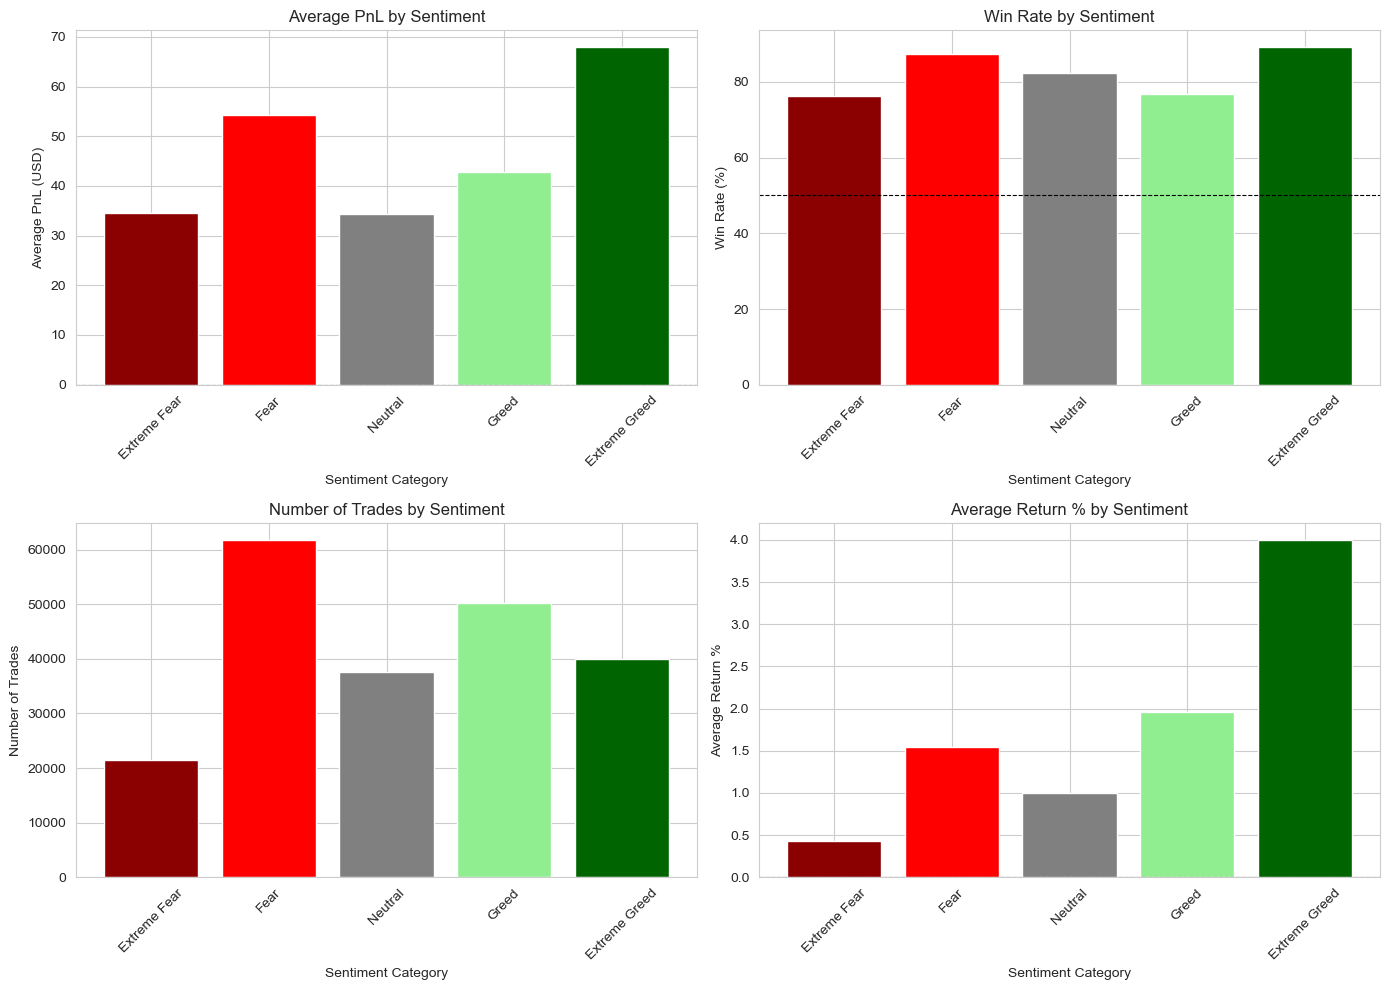

In [12]:
# Filter to only trades with sentiment data
merged_with_sentiment = merged_df[merged_df['sentiment_category'].notna()].copy()
print(f"Trades with sentiment: {len(merged_with_sentiment)}")

# Performance by sentiment category
print("\n" + "="*60)
print("PERFORMANCE BY SENTIMENT CATEGORY")
print("="*60)

sentiment_performance = merged_with_sentiment.groupby('sentiment_category').agg({
    'Closed_PnL': ['sum', 'mean', 'median', 'std', 'count'],
    'is_profitable': 'sum',
    'is_closed': 'sum',
    'Size_USD': 'mean',
    'return_pct': 'mean'
}).reset_index()

sentiment_performance.columns = ['sentiment_category', 'total_pnl', 'avg_pnl', 'median_pnl', 
                                 'pnl_std', 'num_trades', 'num_profitable', 'num_closed', 
                                 'avg_trade_size', 'avg_return_pct']

sentiment_performance['win_rate'] = (sentiment_performance['num_profitable'] / 
                                     sentiment_performance['num_closed'] * 100)

sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_performance['sentiment_category'] = pd.Categorical(
    sentiment_performance['sentiment_category'], 
    categories=sentiment_order, 
    ordered=True
)
sentiment_performance = sentiment_performance.sort_values('sentiment_category')

print("\nPerformance Metrics by Sentiment:")
print(sentiment_performance)

# Visualize performance by sentiment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(sentiment_performance['sentiment_category'], 
               sentiment_performance['avg_pnl'], 
               color=['darkred', 'red', 'gray', 'lightgreen', 'darkgreen'])
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0, 0].set_title('Average PnL by Sentiment')
axes[0, 0].set_xlabel('Sentiment Category')
axes[0, 0].set_ylabel('Average PnL (USD)')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(sentiment_performance['sentiment_category'], 
               sentiment_performance['win_rate'], 
               color=['darkred', 'red', 'gray', 'lightgreen', 'darkgreen'])
axes[0, 1].axhline(y=50, color='black', linestyle='--', linewidth=0.8)
axes[0, 1].set_title('Win Rate by Sentiment')
axes[0, 1].set_xlabel('Sentiment Category')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(sentiment_performance['sentiment_category'], 
               sentiment_performance['num_trades'], 
               color=['darkred', 'red', 'gray', 'lightgreen', 'darkgreen'])
axes[1, 0].set_title('Number of Trades by Sentiment')
axes[1, 0].set_xlabel('Sentiment Category')
axes[1, 0].set_ylabel('Number of Trades')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(sentiment_performance['sentiment_category'], 
               sentiment_performance['avg_return_pct'], 
               color=['darkred', 'red', 'gray', 'lightgreen', 'darkgreen'])
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1, 1].set_title('Average Return % by Sentiment')
axes[1, 1].set_xlabel('Sentiment Category')
axes[1, 1].set_ylabel('Average Return %')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('performance_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Fear vs Greed comparison
print("\n" + "="*60)
print("FEAR VS GREED COMPARISON")
print("="*60)

fear_trades = merged_with_sentiment[merged_with_sentiment['is_fear'] == True]
greed_trades = merged_with_sentiment[merged_with_sentiment['is_greed'] == True]

print(f"\nFear period trades: {len(fear_trades)}")
print(f"Greed period trades: {len(greed_trades)}")

fear_stats = {
    'Total PnL': fear_trades['Closed_PnL'].sum(),
    'Average PnL': fear_trades['Closed_PnL'].mean(),
    'Median PnL': fear_trades['Closed_PnL'].median(),
    'Win Rate': (fear_trades['is_profitable'].sum() / fear_trades['is_closed'].sum() * 100),
    'Avg Trade Size': fear_trades['Size_USD'].mean(),
    'Avg Return %': fear_trades['return_pct'].mean()
}

greed_stats = {
    'Total PnL': greed_trades['Closed_PnL'].sum(),
    'Average PnL': greed_trades['Closed_PnL'].mean(),
    'Median PnL': greed_trades['Closed_PnL'].median(),
    'Win Rate': (greed_trades['is_profitable'].sum() / greed_trades['is_closed'].sum() * 100),
    'Avg Trade Size': greed_trades['Size_USD'].mean(),
    'Avg Return %': greed_trades['return_pct'].mean()
}

comparison = pd.DataFrame({'Fear': fear_stats, 'Greed': greed_stats})
print("\nFear vs Greed Statistics:")
print(comparison)

# Statistical testing
fear_pnl = fear_trades[fear_trades['is_closed']]['Closed_PnL']
greed_pnl = greed_trades[greed_trades['is_closed']]['Closed_PnL']

t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl)
print(f"\nT-test for PnL difference:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant difference")
else:
    print("Result: No statistically significant difference")


FEAR VS GREED COMPARISON

Fear period trades: 83237
Greed period trades: 90295

Fear vs Greed Statistics:
                        Fear         Greed
Total PnL       4.096266e+06  4.865301e+06
Average PnL     4.921208e+01  5.388228e+01
Median PnL      0.000000e+00  0.000000e+00
Win Rate        8.442334e+01  8.245237e+01
Avg Trade Size  7.182011e+03  4.574424e+03
Avg Return %    1.255856e+00  2.866743e+00

T-test for PnL difference:
T-statistic: -0.4036
P-value: 0.6865
Result: No statistically significant difference



PERFORMANCE BY SENTIMENT VALUE RANGES

Performance by Sentiment Value Range:
  sentiment_range     total_pnl     avg_pnl  num_trades  num_profitable  \
0            0-20  6.844400e+05   52.092245       13139            5467   
1           20-40  2.327054e+06   39.158849       59426           24065   
2           40-60  2.886525e+06   49.737662       58035           23134   
3           60-80  2.906849e+06   43.841892       66303           27394   
4          80-100  1.449619e+06  101.265736       14315            6803   

   num_closed   win_rate  
0        6597  82.871002  
1       28599  84.146299  
2       27489  84.157299  
3       33998  80.575328  
4        7719  88.133178  


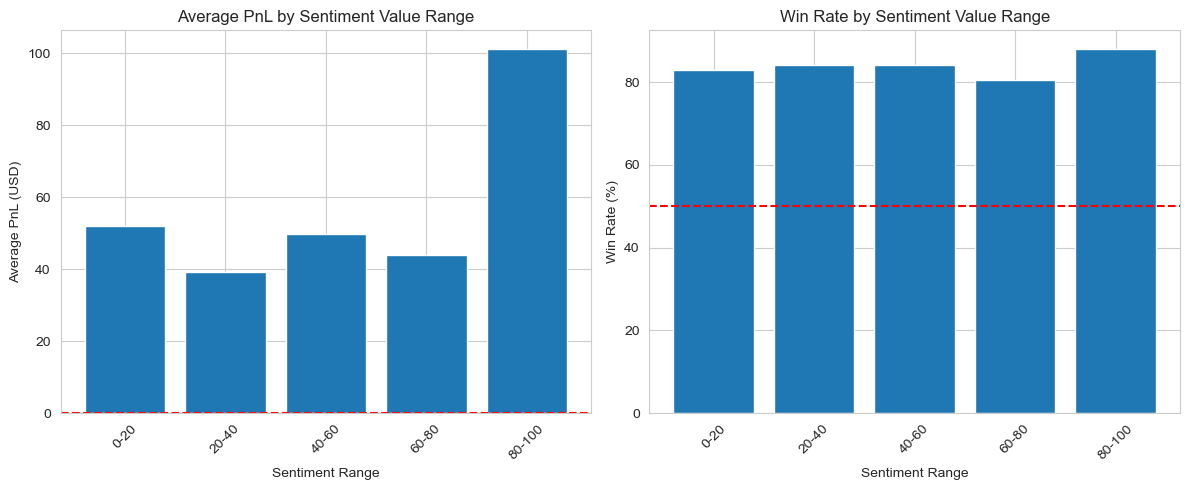

In [14]:
# Performance by sentiment value ranges
print("\n" + "="*60)
print("PERFORMANCE BY SENTIMENT VALUE RANGES")
print("="*60)

merged_with_sentiment['sentiment_range'] = pd.cut(
    merged_with_sentiment['fear_greed_value'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0-20', '20-40', '40-60', '60-80', '80-100']
)

range_performance = merged_with_sentiment.groupby('sentiment_range').agg({
    'Closed_PnL': ['sum', 'mean', 'count'],
    'is_profitable': 'sum',
    'is_closed': 'sum'
}).reset_index()

range_performance.columns = ['sentiment_range', 'total_pnl', 'avg_pnl', 'num_trades', 
                             'num_profitable', 'num_closed']
range_performance['win_rate'] = (range_performance['num_profitable'] / 
                                 range_performance['num_closed'] * 100)

print("\nPerformance by Sentiment Value Range:")
print(range_performance)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range_performance['sentiment_range'].astype(str), range_performance['avg_pnl'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Average PnL by Sentiment Value Range')
plt.xlabel('Sentiment Range')
plt.ylabel('Average PnL (USD)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(range_performance['sentiment_range'].astype(str), range_performance['win_rate'])
plt.axhline(y=50, color='red', linestyle='--')
plt.title('Win Rate by Sentiment Value Range')
plt.xlabel('Sentiment Range')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('performance_by_sentiment_range.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Trader behavior analysis
print("\n" + "="*60)
print("TRADER BEHAVIOR BY SENTIMENT")
print("="*60)

trader_sentiment_behavior = merged_with_sentiment.groupby(['Account', 'sentiment_category']).agg({
    'Closed_PnL': 'sum',
    'Size_USD': 'mean',
    'is_closed': 'sum'
}).reset_index()

trader_sentiment_pivot = trader_sentiment_behavior.pivot(
    index='Account', 
    columns='sentiment_category', 
    values='Closed_PnL'
).fillna(0)

print("\nTop traders during Fear periods:")
fear_columns = [col for col in trader_sentiment_pivot.columns if 'Fear' in col]
if fear_columns:
    fear_total = trader_sentiment_pivot[fear_columns].sum(axis=1).sort_values(ascending=False)
    print(fear_total.head(5))

print("\nTop traders during Greed periods:")
greed_columns = [col for col in trader_sentiment_pivot.columns if 'Greed' in col]
if greed_columns:
    greed_total = trader_sentiment_pivot[greed_columns].sum(axis=1).sort_values(ascending=False)
    print(greed_total.head(5))


TRADER BEHAVIOR BY SENTIMENT

Top traders during Fear periods:
Account
0x083384f897ee0f19899168e3b1bec365f52a9012    1.238143e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    8.827904e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    4.634781e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    3.434149e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    2.960444e+05
dtype: float64

Top traders during Greed periods:
Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    1.639363e+06
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    7.222110e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd    4.535953e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    3.519654e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    3.066642e+05
dtype: float64


In [16]:
# Trade timing analysis
print("\n" + "="*60)
print("TRADE TIMING AND SENTIMENT")
print("="*60)

hourly_sentiment = merged_with_sentiment.groupby(['hour', 'sentiment_category']).agg({
    'Closed_PnL': 'mean',
    'is_closed': 'sum'
}).reset_index()

print("\nBest hours to trade during Fear:")
fear_hourly = hourly_sentiment[hourly_sentiment['sentiment_category'].str.contains('Fear')]
fear_hourly = fear_hourly.groupby('hour').agg({
    'Closed_PnL': 'mean',
    'is_closed': 'sum'
}).sort_values('Closed_PnL', ascending=False)
print(fear_hourly.head(5))

print("\nBest hours to trade during Greed:")
greed_hourly = hourly_sentiment[hourly_sentiment['sentiment_category'].str.contains('Greed')]
greed_hourly = greed_hourly.groupby('hour').agg({
    'Closed_PnL': 'mean',
    'is_closed': 'sum'
}).sort_values('Closed_PnL', ascending=False)
print(greed_hourly.head(5))



TRADE TIMING AND SENTIMENT

Best hours to trade during Fear:
      Closed_PnL  is_closed
hour                       
1     151.216184       2549
8     146.570943       2382
12    144.883999       1611
7     104.507966       2171
11     88.912888        844

Best hours to trade during Greed:
      Closed_PnL  is_closed
hour                       
10    115.512798       1691
13    102.675896       2273
15     99.974829       1702
20     98.495978       2581
19     96.189656       2548



POSITION DIRECTION BY SENTIMENT

Performance by Position Direction and Sentiment:
  sentiment_category position_type    avg_pnl   win_rate  num_trades
0       Extreme Fear         Short  29.957743  63.505055        8143
1       Extreme Fear          Long  37.351161  84.660909       13257
2      Extreme Greed         Short  85.694715  89.377289       26488
3      Extreme Greed          Long  32.974651  88.768569       13504
4               Fear         Short  71.270514  83.724832       26721
5               Fear          Long  41.369633  89.868147       35116
6              Greed         Short  42.582292  72.343523       33722
7              Greed          Long  43.071541  86.651669       16581
8            Neutral         Short  43.829734  77.734135       17444
9            Neutral          Long  26.101907  86.176588       20242


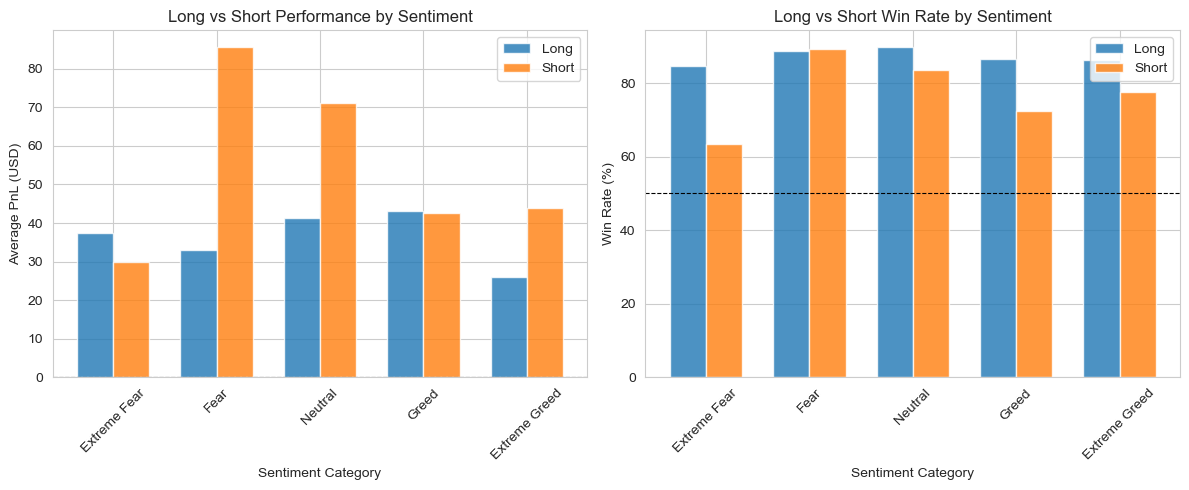

In [17]:
# Position direction analysis
print("\n" + "="*60)
print("POSITION DIRECTION BY SENTIMENT")
print("="*60)

direction_sentiment = merged_with_sentiment.groupby(['sentiment_category', 'is_long']).agg({
    'Closed_PnL': ['sum', 'mean', 'count'],
    'is_profitable': 'sum',
    'is_closed': 'sum'
}).reset_index()

direction_sentiment.columns = ['sentiment_category', 'is_long', 'total_pnl', 'avg_pnl', 
                               'num_trades', 'num_profitable', 'num_closed']
direction_sentiment['win_rate'] = (direction_sentiment['num_profitable'] / 
                                   direction_sentiment['num_closed'] * 100)
direction_sentiment['position_type'] = direction_sentiment['is_long'].map({True: 'Long', False: 'Short'})

print("\nPerformance by Position Direction and Sentiment:")
print(direction_sentiment[['sentiment_category', 'position_type', 'avg_pnl', 'win_rate', 'num_trades']])

plt.figure(figsize=(12, 5))

long_data = direction_sentiment[direction_sentiment['is_long'] == True]
short_data = direction_sentiment[direction_sentiment['is_long'] == False]

x = np.arange(len(sentiment_order))
width = 0.35

plt.subplot(1, 2, 1)
if not long_data.empty:
    plt.bar(x - width/2, long_data['avg_pnl'], width, label='Long', alpha=0.8)
if not short_data.empty:
    plt.bar(x + width/2, short_data['avg_pnl'], width, label='Short', alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Sentiment Category')
plt.ylabel('Average PnL (USD)')
plt.title('Long vs Short Performance by Sentiment')
plt.xticks(x, sentiment_order, rotation=45)
plt.legend()

plt.subplot(1, 2, 2)
if not long_data.empty:
    plt.bar(x - width/2, long_data['win_rate'], width, label='Long', alpha=0.8)
if not short_data.empty:
    plt.bar(x + width/2, short_data['win_rate'], width, label='Short', alpha=0.8)
plt.axhline(y=50, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Sentiment Category')
plt.ylabel('Win Rate (%)')
plt.title('Long vs Short Win Rate by Sentiment')
plt.xticks(x, sentiment_order, rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('position_direction_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()



In [18]:
print("\nSentiment-Performance analysis complete!")
print("Generated plots:")
print("- performance_by_sentiment.png")
print("- performance_by_sentiment_range.png")
print("- position_direction_sentiment.png")


Sentiment-Performance analysis complete!
Generated plots:
- performance_by_sentiment.png
- performance_by_sentiment_range.png
- position_direction_sentiment.png


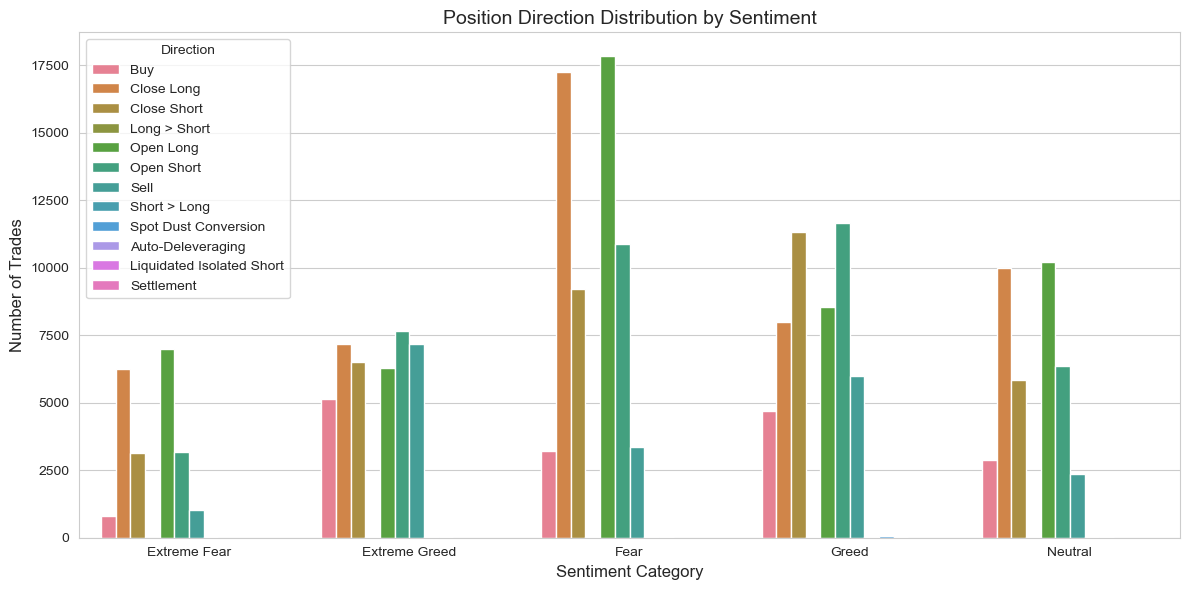

In [21]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Group by sentiment and direction
direction_counts = merged_df.groupby(['sentiment_category', 'Direction']).size().reset_index(name='count')

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=direction_counts,
    x='sentiment_category',
    y='count',
    hue='Direction'
)

plt.title('Position Direction Distribution by Sentiment', fontsize=14)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Trades', fontsize=12)
plt.legend(title='Direction')
plt.tight_layout()
plt.show()

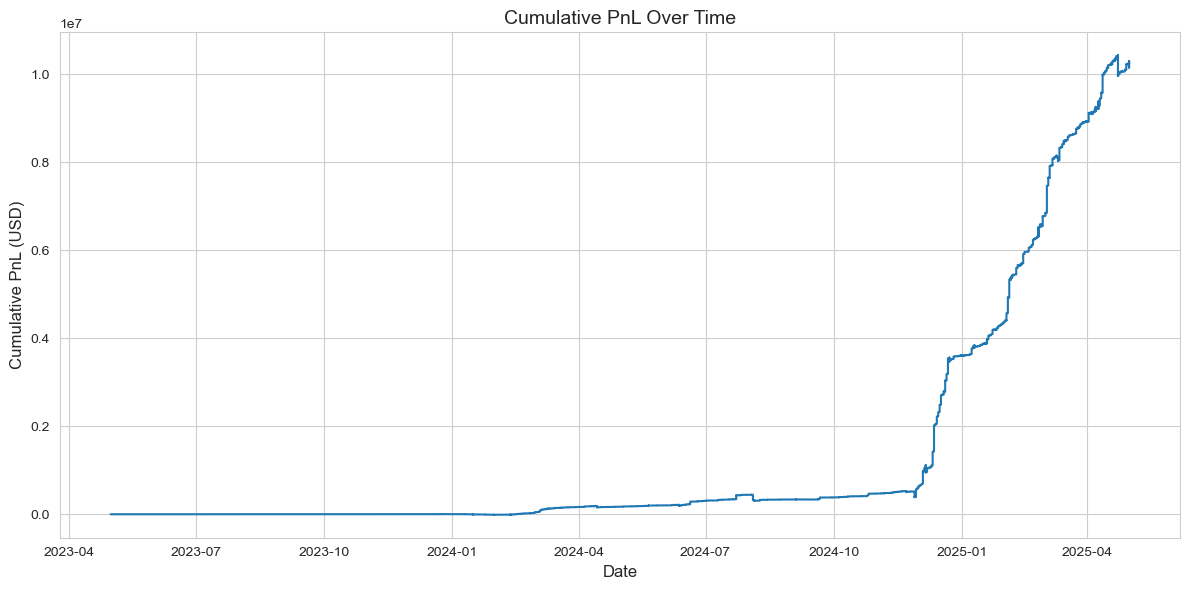

In [22]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Ensure sorted by date
df_sorted = merged_df.sort_values('trade_date')

# Compute cumulative PnL
df_sorted['cumulative_pnl'] = df_sorted['Closed_PnL'].cumsum()

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['trade_date'], df_sorted['cumulative_pnl'])

plt.title('Cumulative PnL Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative PnL (USD)', fontsize=12)

plt.tight_layout()
plt.show()
